# CMSC320: Checkpoint 2
Tyshon Brown, David Li, Zile Liu, and Samuel Opoku-Agyemang


## Data Pre-Processing

### Imports

In [71]:
import pandas as pd
import numpy as np

import json

from census import Census
from us import states

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# sam's API key: 23c580dcbb047d99e93502f60681fc6430f2fc9a
c = Census("23c580dcbb047d99e93502f60681fc6430f2fc9a", year = 2020)


### Population

In [72]:
population_data = c.acs5.state(('NAME', 'B01003_001E'), Census.ALL)
population = pd.DataFrame(population_data)
population.rename(columns={'NAME': 'Name', 'B01003_001E': 'Population'}, inplace=True)
population['Population'] = population['Population'].astype(int)

population = population.drop('state', axis=1)
population.head()

,Name,Population
0,Pennsylvania,12794885
1,California,39346023
2,West Virginia,1807426
3,Utah,3151239
4,New York,19514849


### Population Density

In [73]:
# https://www.census.gov/data/tables/time-series/dec/density-data-text.html
# renamed from "apportionment.csv"
pop_density = pd.read_csv("population_density.csv")
pop_density = pop_density[['Name', 'Geography Type', 'Year', 'Resident Population Density']]
pop_density = pop_density[(pop_density['Year'] == 2020) & (pop_density['Geography Type'] == "State")]
pop_density = pop_density[['Name', 'Resident Population Density']].reset_index(drop = True)

# 52 datapoints because DC and Puerto Rico count as states
pop_density.head()

,Name,Resident Population Density
0,Alabama,99.2
1,Alaska,1.3
2,Arizona,62.9
3,Arkansas,57.9
4,California,253.7


### Median Age

In [74]:
median_age_dictionary = c.acs5.state(('NAME', 'B01002_001E'), Census.ALL)
median_age = pd.DataFrame.from_dict(median_age_dictionary).rename(columns = {'NAME' : 'Name', 'B01002_001E' : 'Median Age'})
median_age = median_age[['Name', 'Median Age']].sort_values(by = ['Name']).reset_index(drop = True)
median_age.head()


,Name,Median Age
0,Alabama,39.2
1,Alaska,34.6
2,Arizona,37.9
3,Arkansas,38.3
4,California,36.7


### Median Income

In [75]:
median_income_dictionary = c.acs5.state(('NAME', 'B19013_001E'), Census.ALL)
median_income = pd.DataFrame.from_dict(median_income_dictionary).rename(columns = {'NAME' : 'Name', 'B19013_001E' : 'Median Household Income'})
median_income = median_income[['Name', 'Median Household Income']].sort_values(by = ['Name']).reset_index(drop = True)
median_income.head()

,Name,Median Household Income
0,Alabama,52035.0
1,Alaska,77790.0
2,Arizona,61529.0
3,Arkansas,49475.0
4,California,78672.0


### Popular Vote

In [76]:
# https://www.fec.gov/introduction-campaign-finance/election-results-and-voting-information/federal-elections-2020/
popular_vote = pd.read_csv("federalelections2020.csv")
popular_vote.head()

,Name,Biden Votes,Trump Votes,Total Votes
0,Alabama,849624,1441170,2323282
1,Alaska,153778,189951,359530
2,Arizona,1672143,1661686,3387326
3,Arkansas,423932,760647,1219069
4,California,11110639,6006518,17501380


## Hypothesis Testing

*Likely just going to focus on either the 2020 presidential election because the FEC data for Trump's 2024 campaign is unclean, scattered, and not even on the main page as it was in previous elections.*

Electoral college and popular vote numbers by state: https://www.fec.gov/resources/cms-content/documents/2024presgeresults.pdf

**ideas**
- how does median age correlate with funding/spending
- how does population density correlate spending / voter turnout
- how does median income correlate with chosen candidate

### Median Age and Spending
*How does median age correlate with campaign spending?* \
*Do campaigns spend more on states/areas with a lower median age?*

### Population Density and Voter Turnout
*How does population density correlate with voter turnout?* \
*Do denser areas have more engaged voters?*

Turnout Rate:

In [79]:
popular_vote['Turnout'] = popular_vote['Total Votes'] / population['Population']
popular_vote.head()

,Name,Biden Votes,Trump Votes,Total Votes,Turnout
0,Alabama,849624,1441170,2323282,0.181579
1,Alaska,153778,189951,359530,0.009138
2,Arizona,1672143,1661686,3387326,1.874116
3,Arkansas,423932,760647,1219069,0.386854
4,California,11110639,6006518,17501380,0.896824


Combining DF's for Visualization:

In [83]:
# merging Popular Vote and Population Density and Population
density_turnout = popular_vote.merge(pop_density, on='Name').merge(population, on='Name')

# Calculating turnout and adding it to the df
density_turnout['Turnout'] = density_turnout['Total Votes'] / density_turnout['Population'] * 100
density_turnout['Resident Population Density'] = pd.to_numeric(density_turnout['Resident Population Density'], errors='coerce')

# Dropping Na's
density_turnout = density_turnout.dropna(subset=['Resident Population Density', 'Turnout'])

density_turnout.head()

,Name,Biden Votes,Trump Votes,Total Votes,Turnout,Resident Population Density,Population
0,Alabama,849624,1441170,2323282,47.479945,99.2,4893186
1,Alaska,153778,189951,359530,48.783566,1.3,736990
2,Arizona,1672143,1661686,3387326,47.216278,62.9,7174064
3,Arkansas,423932,760647,1219069,40.475445,57.9,3011873
4,California,11110639,6006518,17501380,44.480684,253.7,39346023


The Plot:
- x-axis: Population Density
- y-axis: Voter Turnout
- dots/points: scaled to the population size

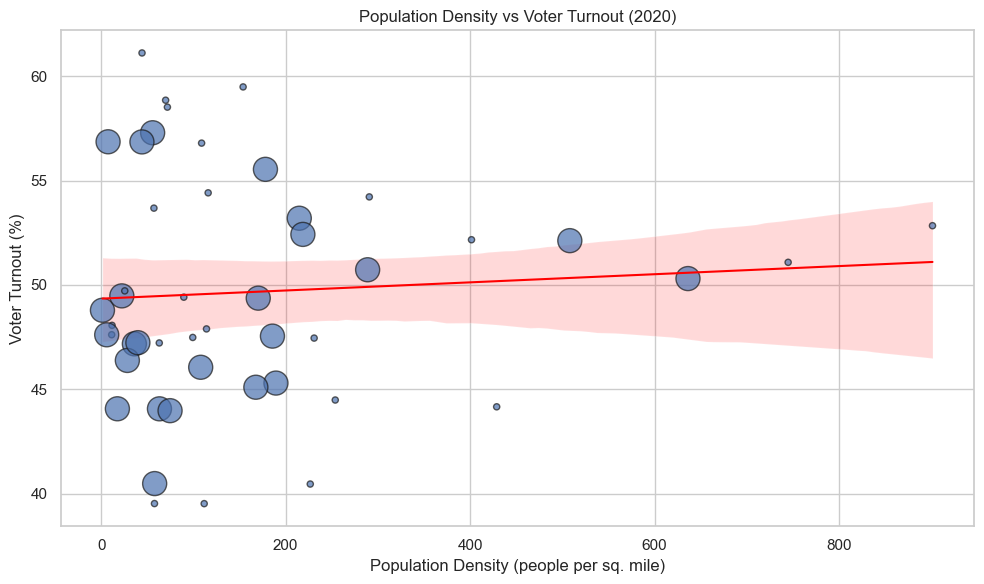

In [85]:

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Regression Line
sns.regplot(data=density_turnout, x='Resident Population Density', y='Turnout', scatter=False, color='red', line_kws={'linewidth':1.5})

# Scatter Plot
plt.scatter(
    x=density_turnout['Resident Population Density'],
    y=density_turnout['Turnout'],
    s=density_turnout['Population'] / 500000,
    sizes=(20, 300),
    alpha=0.7,
    edgecolor='k'
)

plt.xlabel("Population Density (people per sq. mile)")
plt.ylabel("Voter Turnout (%)")
plt.title("Population Density vs Voter Turnout (2020)")
plt.tight_layout()
plt.show()

### Median Income and Funding/Spending
*Do wealthier states contribute disproportionately more to campaigns?*
*Do poorer states receive more campaign spending?*

In [8]:
# if we choose to compare all three, it could be x-axis income, y-axis spending, and dot color candidate

### Campaign Spending and Chosen Candidate
*Does increased spending always lead to more votes?*